# 05.4 Forecasting

Forecasting is the art of taking an educated guess at what future data might look like. A good forecast can inform you on several business decisions you might have to make.

In several business models, forecasting can help you make informed decisions to improve person-power allocation, scheduling, or logistical decisions.

When you are operating with limited information (no external pressure from current events, like pendemics, wars, volcaninc eruptions), a simple extrapolation can already offer you some clues of what is __most likely to happen__ and not __what will happen__.

With the help of datetime, and if the cycles of your observable match up with a pre-defined cycle (week, month, day, year), it can be easy to produce a forecast with an __confidence interval__.

---
## Forecast based on past observations with cyclical behaviour

Let's recover the temperature example from the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.__version__ #make sure you have at least version 1.2

'1.3.5'

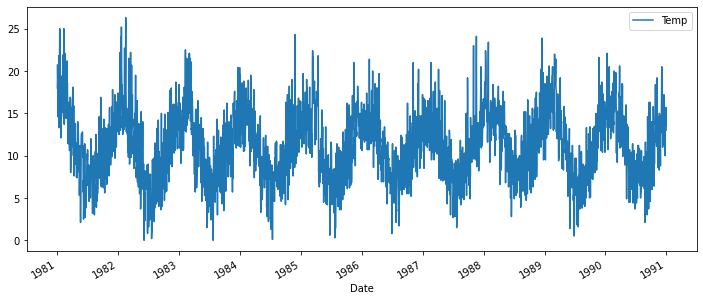

In [3]:
temp_file = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

dtemp = pd.read_csv(temp_file)
temp_series = dtemp.set_index('Date')
temp_series.index = pd.to_datetime(temp_series.index)

fig, ax = plt.subplots(figsize=(12,5))
temp_series.plot(ax=ax)
plt.show()

Assume we wish to do a daily average over the several years. There are many ways of doing this with pandas. We will just solve the problem by adding a column with "day_of_year".

In [4]:
temp_series.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
temp_series['day_of_year'] = temp_series.index.day_of_year

In [6]:
temp_series.head()

,Temp,day_of_year
Date,,
1981-01-01,20.7,1
1981-01-02,17.9,2
1981-01-03,18.8,3
1981-01-04,14.6,4
1981-01-05,15.8,5


In [7]:
temp_series.tail()

,Temp,day_of_year
Date,,
1990-12-27,14.0,361
1990-12-28,13.6,362
1990-12-29,13.5,363
1990-12-30,15.7,364
1990-12-31,13.0,365


Now we need to group this dataframe into a new dataframe where the index will be the "day_of_year".

In [8]:
dayyeardf = temp_series.groupby(by='day_of_year').mean()

In [9]:
dayyeardf.head()

,Temp
day_of_year,
1,15.85
2,15.28
3,14.69
4,14.04
5,13.85


<AxesSubplot:xlabel='day_of_year'>

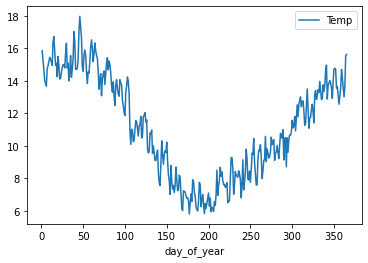

In [10]:
dayyeardf.plot()

This can provide an average value for what we are expecting, but for a better forecast, and also to have an idea if we are encountering outliers, we should also include the Standard deviation. Let's regroup the time series again with more info.

In [11]:
dayyear = temp_series.groupby(by='day_of_year').Temp.agg(['mean','std'])

In [12]:
dayyear

,mean,std
day_of_year,,
1,15.85,2.911376
2,15.28,1.636256
3,14.69,2.884229
4,14.04,1.758914
5,13.85,1.681435
...,...,...
361,13.60,2.048848
362,13.01,1.678922
363,13.64,1.826472


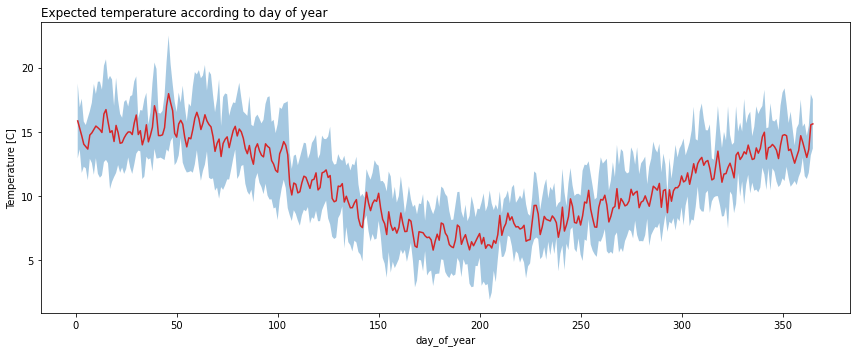

In [13]:
fig, ax = plt.subplots(figsize=(12,5))

ax.fill_between(dayyear.index,
                dayyear['mean'] - dayyear['std'],
                dayyear['mean'] + dayyear['std'],
                alpha=0.4)

dayyear['mean'].plot(ax=ax, c='C3')

ax.set_ylabel("Temperature [C]")

plt.title("Expected temperature according to day of year", loc='left')
plt.tight_layout()
plt.show()

---
## Forecasting more complex observations

The most common family of forecasting models are the __ARIMA: Auto-Regressive integrated Moving Average__. 

In the persepctive of Time-Series analysis, stationary might mean, according to who you ask:

* Data with a periodic repetition only. For example, a stationary yearly model would always have the same approximate value in the same month, like the daily temperatures.
* Data which is just a trendline. Some mechanism with no seasonality and a easy to explain trend (a linear increase of some KPI).

As we've seen before, most KPIs may not have only a stationary component, meaning the standard ARIMA might not be sufficient. As we will see, there are some extensions that allow to cover most cases.

The basic ARIMA function has three parameters:

* __AR(p)__: Auto-Regressive term: The number of lag observations included in the model: How many past observations I consider to influence directly the next observation. 
* __I(d)__: Integrating term: The number of times that the raw observations are differenced, i.e., how many past observation can contribute to generate a baseline for the next observation.
* __MA(q)__: Moving-Average term: Size of the moving average window, or Order of moving average.

There are many combinations of values for (p, d, q). You can see a list of the [most common combinations here](https://people.duke.edu/~rnau/411arim.htm).

ARIMA models can be very heavy to train when you have many observations. We will use a small dataset to exemplify.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
#Create a simple dataset
npts = 100
x = np.arange(0, npts)
data = np.arange(0, npts) + 3*np.random.randn(npts)

In [ ]:
# fit 
model = ARIMA(data, order=(5, 1, 1))
model_fit = model.fit()

#Make the following number of predictions
additional_points = 10

yhat = model_fit.predict(len(data), len(data)+additional_points-1, typ='levels')
xhat = np.arange(0, additional_points) + npts + 1.0

plt.plot(x, data)
plt.plot(xhat, yhat)

ARIMAs are nice for short term prediction. You need to keep retraining the model for new predictions as soon as you have new data, in a sliding fashion. But ARIMAs can get very complicated very fast:

In [ ]:
## Monthly sunspots
chosen_file = '../Files/monthly-sunspots.csv'

df = pd.read_csv(chosen_file)
time_series = df.set_index(df.columns[0])
time_series.index = pd.to_datetime(time_series.index)

In [ ]:
time_series.plot()

In [ ]:
npts = 2 * 11 * 12 ## Two solar cycles: 22 years

train = time_series[:-npts]
test = time_series[-npts:]

In [ ]:
#data = time_series.values

## Some warnings here is OK
model = ARIMA(train.values, order=(1, 1, 7), dates=train.index)
model_fit = model.fit()

In [ ]:
#model_fit.summary()

In [ ]:
forecast_data =  model_fit.predict(len(train), len(train)+npts-1)
forecast_index = test.index

forecast = pd.Series(data=forecast_data, index=forecast_index)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
forecast.plot(ax=ax)
test.plot(ax=ax)
#plt.xlim('1962', '1966')
##plt.ylim(0, 1000)
plt.show()

Predicting the next few years gives us not such a bad result. But after a while we would need to retrain the model and re-forecast. The ARIMA family is good for the next few observations but is is very hard to tune for the long-term. ARIMA tunning is hard to understand. Currently, ARIMAs are being replaced by Neural-Network approaches, namely Convolutional Neural Netowrks (CNNs). Easier to understand, thus also easier to train. Let's see one last example with an ARIMA extension: __SARIMAX__. SARIMAX stands for Seasonal ARIMA with eXogenous factors. It is an ARIMA model enriched with a Seasonal component. The Exgoneous variety means we have to impose outside conditions on the model. It is possible, through several statistical testing, to determine the best (p,d,q) for an ARIMA. As soon as you bring outside (Exogenous) factors, you must force the model to use them, and you must get information from outside of the current observables you have.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Besides the basic ARIMA (p,d,q) parameters, the process also has Exogenous parameters (P, D, Q, m). The capital letters are relative not to the observed data's definitions, but to Outsider knowloedge we have and impose on the analysis. So the "p" of the data must observe the "P" of the mechanism that creates it. The additional parameter "m" refers to the number of points in the data for a seasonal cycle. In our case, it's monthly data in a yearly cycle, so we have m=12.

In [ ]:
airline_file = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dair = pd.read_csv(airline_file, index_col='Month')
dair.index = pd.to_datetime(dair.index)

train = dair[:-12]
test = dair[-12:]

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

train.plot(ax=ax)
test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.tight_layout()
plt.show()

In [ ]:
model = SARIMAX(train['Passengers'],
                order = (2, 1, 1),  
                seasonal_order =(2, 1, 1, 12))

model_fit = model.fit()

In [ ]:
yhat = model_fit.predict(start=len(train), end=len(train)+12-1)

In [ ]:
predictdf = pd.Series(index=test.index, data=yhat)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')

predictdf.plot(ax=ax, c='C3')

plt.legend(['Train', 'Test', 'Prediction'])
plt.tight_layout()
plt.show()

The ARIMA family is hard to tune, there's why you usually train it with __brute force__.

---
### Auto-ARIMA

Sometimes you will need to perform forecasts of very complex datasets. When the data is hard to understand, auto-ML might become a solution. It goes beyond the scope of this class, but you can have an auto-ARIMA model scanning a pre-defined parameter space for the model terms and then returning the best set of points, defined by minimizing the RMSE (root mean square error) between a test set and the output of the model.

In [ ]:
# Import auto_arima
from pmdarima import auto_arima 
  
# Ignore the warnings, as some parameters may be incompatible with some ARIMA settings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit the several
stepwise_fit = auto_arima(dair['Passengers'],
                          start_p = 1,
                          start_q = 1, 
                          max_p = 3,
                          max_q = 3,
                          m = 12, 
                          start_P = 0,
                          seasonal = True, 
                          d = None,
                          D = 1,
                          trace = True, 
                          error_action ='ignore',   # Ignore incompatible settings
                          suppress_warnings = True,  
                          stepwise = True)           
  
# To print the summary 
stepwise_fit.summary() 

In [ ]:
prediction = pd.DataFrame(stepwise_fit.predict(n_periods = 24))#, index=dair.index)

In [ ]:
prediction.head()

In [ ]:
prediction['Time'] = pd.date_range(start='1961-01-01', periods=24, freq='MS')

In [ ]:
prediction.head()

In [ ]:
prediction.set_index('Time', inplace=True)

In [ ]:
dair

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

dair.plot(ax=ax, legend='Train')
prediction.plot(ax=ax, label='Prediction')

plt.legend(['Train', 'Prediction'])
plt.tight_layout()
plt.show()